In [2]:
%matplotlib widget
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from math import atan2, cos, sin, sqrt

In [3]:
sys.path.append(os.path.dirname(os.getcwd()))
from utils.nb import isnotebook
from utils.viz.viz import plot_fustrum, plot_crs, set_3d_axes_equal

In [4]:
def M_opk(o, p, k):
    # Construction of Rotation matrix from Euler Angles (omega, phi, kppa) --> in this order!
    M = ([
        cos(p) * cos(k),
        cos(o) * sin(k) + sin(o) * sin(p) * cos(k),
        sin(o) * sin(k) - cos(o) * sin(p) * cos(k)
    ], [
        -cos(p) * sin(k),
        cos(o) * cos(k) - sin(o) * sin(p) * sin(k),
        sin(o) * cos(k) + cos(o) * sin(p) * sin(k)
    ], [sin(p), -sin(o) * cos(p), cos(o) * cos(p)])
    return M

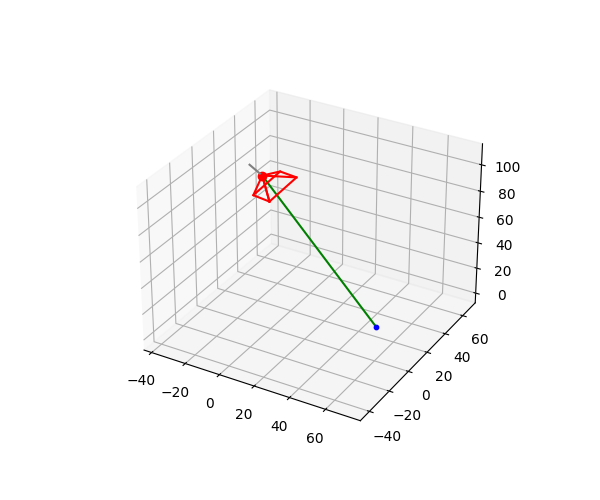

In [5]:
P_w = np.array([50, 20, 0])
C = np.array([-10, +10, 100])
opk = [np.deg2rad(25), np.deg2rad(30), np.deg2rad(-70)]
R = np.array(M_opk(opk[0], opk[1], opk[2]))

plt.figure(figsize=(6,5))
ax = plt.axes(projection='3d')
ax.scatter3D(C[0], C[1], C[2], c='r', s=10)
ax.scatter3D(P_w[0], P_w[1], P_w[2], c='b', s=10)
ax.plot3D([C[0], P_w[0]], [C[1], P_w[1]], [C[2], P_w[2]], 'g-')
plot_fustrum(ax, C, R, f=-1.0, scale=10)
set_3d_axes_equal(ax)

In [6]:
# backproject: compute normalized coordinates
P_c = R @ P_w - R @ C
p_n = [-P_c[0]/P_c[2], -P_c[1]/P_c[2]]

In [7]:
# forward computation with known depth
d = P_c[2]
P_w_chk = R.T @ np.array([-p_n[0], -p_n[1], 1.0])*d + C
print('chk ~= 0: ', np.linalg.norm(P_w_chk - P_w))

chk ~= 0:  1.7763568394002505e-14


In [8]:
import sympy as sym

def M_opk_s(o, p, k):
    cos = sym.cos
    sin = sym.sin
    M = sym.Matrix(([
        cos(p) * cos(k),
        cos(o) * sin(k) + sin(o) * sin(p) * cos(k),
        sin(o) * sin(k) - cos(o) * sin(p) * cos(k)
    ], [
        -cos(p) * sin(k),
        cos(o) * cos(k) - sin(o) * sin(p) * sin(k),
        sin(o) * cos(k) + cos(o) * sin(p) * sin(k)
    ], [sin(p), -sin(o) * cos(p), cos(o) * cos(p)]))
    return M

In [9]:
o, p, k = sym.symbols('o p k')
M_sym = M_opk_s(o, p, k)
chk = R - np.array(M_sym.subs([(o, opk[0]),(p, opk[1]), (k, opk[2])]))
print('chk ~=0: ', np.sum(np.abs(chk)))

chk ~=0:  0


In [10]:
o, p, k, x, y, z, p_x, p_y, ds = sym.symbols('o p k x y z p_x p_y d')
M_sym = M_opk_s(o, p, k)
P_w_s = M_sym.T @ sym.Matrix([-p_x, -p_y, 1.0])*ds + sym.Matrix([x, y, z])

P_w_chk = P_w_s.subs([(o, opk[0]),(p, opk[1]), (k, opk[2]), (x, C[0]), (y, C[1]), (z, C[2]), (p_x, p_n[0]), (p_y, p_n[1]), (ds, d)])
print('chk ~=0: ', np.sum(np.abs(np.array(P_w_chk).reshape(-1) - P_w)))

chk ~=0:  2.84217094304040e-14


In [11]:
J_x = P_w_s.jacobian([o, p, k, ds])
W = sym.eye(4)
W[0, 0] = np.deg2rad(0.01)**2
W[1, 1] = np.deg2rad(0.01)**2
W[2, 2] = np.deg2rad(0.01)**2
W[3, 3] = np.deg2rad(0.01)**2

J_f = J_x @ W @ J_x.T

print(J_f.shape)
print(J_f[0, 0])
print(J_f[1, 1])
print(J_f[2, 2])

(3, 3)
3.04617419786709e-8*d**2*(p_x*sin(k)*cos(p) + p_y*cos(k)*cos(p))**2 + 3.04617419786709e-8*d**2*(p_x*sin(p)*cos(k) - p_y*sin(k)*sin(p) + 1.0*cos(p))**2 + (-p_x*cos(k)*cos(p) + p_y*sin(k)*cos(p) + 1.0*sin(p))*(-3.04617419786709e-8*p_x*cos(k)*cos(p) + 3.04617419786709e-8*p_y*sin(k)*cos(p) + 3.04617419786709e-8*sin(p))
3.04617419786709e-8*d**2*(-p_x*(-sin(k)*sin(o)*sin(p) + cos(k)*cos(o)) - p_y*(-sin(k)*cos(o) - sin(o)*sin(p)*cos(k)))**2 + 3.04617419786709e-8*d**2*(-p_x*(-sin(k)*sin(o) + sin(p)*cos(k)*cos(o)) - p_y*(-sin(k)*sin(p)*cos(o) - sin(o)*cos(k)) - 1.0*cos(o)*cos(p))**2 + 3.04617419786709e-8*d**2*(-p_x*sin(o)*cos(k)*cos(p) + p_y*sin(k)*sin(o)*cos(p) + 1.0*sin(o)*sin(p))**2 + (-p_x*(sin(k)*cos(o) + sin(o)*sin(p)*cos(k)) - p_y*(-sin(k)*sin(o)*sin(p) + cos(k)*cos(o)) - 1.0*sin(o)*cos(p))*(-3.04617419786709e-8*p_x*(sin(k)*cos(o) + sin(o)*sin(p)*cos(k)) - 3.04617419786709e-8*p_y*(-sin(k)*sin(o)*sin(p) + cos(k)*cos(o)) - 3.04617419786709e-8*sin(o)*cos(p))
3.04617419786709e-8*d**2*

In [12]:
var_x = J_f[0, 0].subs([(o, opk[0]),(p, opk[1]), (k, opk[2]), (x, C[0]), (y, C[1]), (z, C[2]), (p_x, p_n[0]), (p_y, p_n[1]), (ds, d)])
var_y = J_f[1, 1].subs([(o, opk[0]),(p, opk[1]), (k, opk[2]), (x, C[0]), (y, C[1]), (z, C[2]), (p_x, p_n[0]), (p_y, p_n[1]), (ds, d)])
var_z = J_f[2, 2].subs([(o, opk[0]),(p, opk[1]), (k, opk[2]), (x, C[0]), (y, C[1]), (z, C[2]), (p_x, p_n[0]), (p_y, p_n[1]), (ds, d)])

print(var_x**0.5, var_y**0.5, var_z**0.5)

0.0173005928846436 0.0247258989371328 0.0107412651435580


Text(0, 0.5, 'Std [m]')

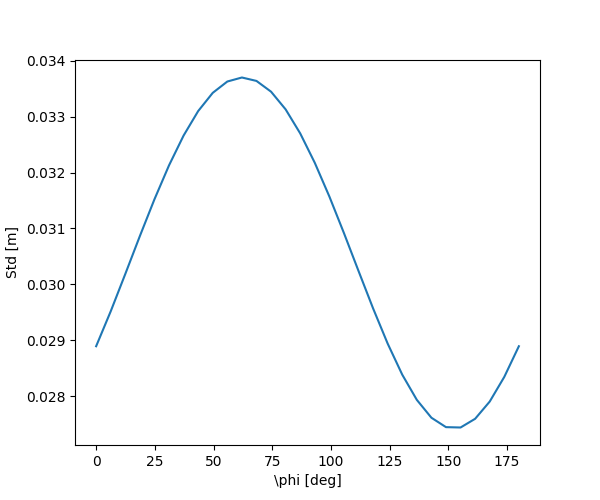

In [13]:
stds = []
for p_ang in np.linspace(0, np.pi, 30):
    var_x = J_f[0, 0].subs([(o, opk[0]),(p, p_ang), (k, opk[2]), (x, C[0]), (y, C[1]), (z, C[2]), (p_x, p_n[0]), (p_y, p_n[1]), (ds, d)])
    var_y = J_f[1, 1].subs([(o, opk[0]),(p, p_ang), (k, opk[2]), (x, C[0]), (y, C[1]), (z, C[2]), (p_x, p_n[0]), (p_y, p_n[1]), (ds, d)])
    var_z = J_f[2, 2].subs([(o, opk[0]),(p, p_ang), (k, opk[2]), (x, C[0]), (y, C[1]), (z, C[2]), (p_x, p_n[0]), (p_y, p_n[1]), (ds, d)])
    stds.append([p_ang, float(var_x + var_y + var_z)**0.5])
    
stds = np.array(stds)

plt.figure(figsize=(6,5))
plt.plot(np.rad2deg(stds[:, 0]), stds[:, 1])
plt.xlabel('\phi [deg]')
plt.ylabel('Std [m]')

Text(0, 0.5, '\\sigma [m]')

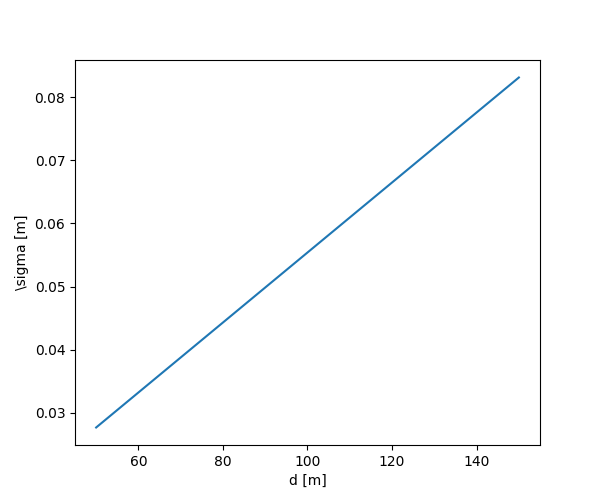

In [14]:
stds = []
for param_d in np.linspace(50, 150, 25):
    var_x = J_f[0, 0].subs([(o, opk[0]),(p, p_ang), (k, opk[2]), (x, C[0]), (y, C[1]), (z, C[2]), (p_x, p_n[0]), (p_y, p_n[1]), (ds, param_d)])
    var_y = J_f[1, 1].subs([(o, opk[0]),(p, p_ang), (k, opk[2]), (x, C[0]), (y, C[1]), (z, C[2]), (p_x, p_n[0]), (p_y, p_n[1]), (ds, param_d)])
    var_z = J_f[2, 2].subs([(o, opk[0]),(p, p_ang), (k, opk[2]), (x, C[0]), (y, C[1]), (z, C[2]), (p_x, p_n[0]), (p_y, p_n[1]), (ds, param_d)])
    stds.append([param_d, float(var_x + var_y + var_z)**0.5])
    
stds = np.array(stds)

plt.figure(figsize=(6,5))
plt.plot(stds[:, 0], stds[:, 1])
plt.xlabel('d [m]')
plt.ylabel('\sigma [m]')

Text(0, 0.5, 'Weight [-]')

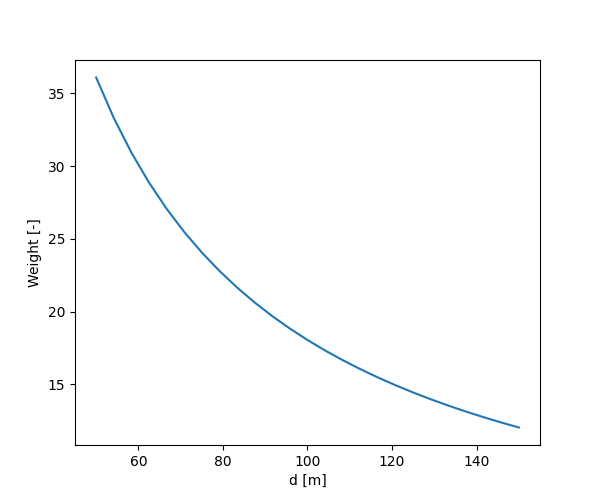

In [15]:
plt.figure(figsize=(6,5))
plt.plot(stds[:, 0], 1/stds[:, 1])
plt.xlabel('d [m]')
plt.ylabel('Weight [-]')